# Transfer Learning for MNIST
In this notebook you're going to explore transfer learning techniques in application to MNIST (handwritten digits) dataset.

In [1]:
import numpy as np
import pandas as pd

import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import he_normal
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split

from IPython.display import SVG

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


Set style

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Just for the sake of reproducibility

In [3]:
np.random.seed(41)

# Data

## MNIST overview

Let's download MNIST dataset. There is a special function in Keras for that purpose (because MNIST is extremely popular)

In [4]:
(X_train, y_train), (X_valid, y_valid) = mnist.load_data()
print(len(X_train), 'train samples')
print(len(X_valid), 'validation samples')

60000 train samples
10000 validation samples


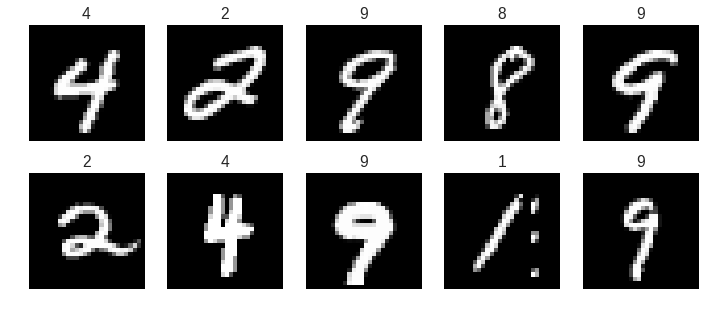

In [5]:
plt.figure(figsize=(12, 5))
for num, i in enumerate(np.random.choice(len(X_train), 10)):
    plt.subplot(2, 5, num + 1)
    plt.imshow(X_train[i], cmap="Greys_r")
    plt.axis("off")
    plt.title(str(y_train[i]))

Let's see objects are distributed among classes

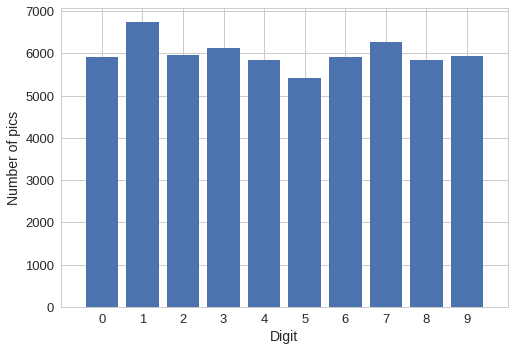

In [6]:
x_bars, y_bars = np.unique(y_train, return_counts=True)
plt.bar(x_bars, y_bars)
plt.xlim([-1, 10])
plt.xticks(np.arange(10))
plt.xlabel("Digit", fontsize=14)
plt.ylabel("Number of pics", fontsize=14)
plt.show()

As one can see, the task is pretty balanced

## Data preparation

First of all, let's predefine image parameters:
* **img_rows, img_cols** $-$ 2D dimension of a pictures; for MNIST it is $28 \times 28$
* **nb_classes** $-$ number of classes (digits in our case)

In [7]:
img_rows, img_cols = 28, 28
nb_classes = 10

Theano and Tensorflow both are tensor-based libraries. It means that all objects inside it, all inputs and outputs are **tensors**. One can treat tensor as a simple multidimensional array.

In [8]:
X_train.shape

(60000, 28, 28)

Here we're going to use dense baseline models so we need to represent our data as 1-dimensional vectors

In [9]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)

Now the vectors are flattened

In [10]:
X_train.shape

(60000, 784)

Tensorflow prefers to work with $\text{float32}$ data type. So the next step is to cast data. Also let's have our data in $[0; 1]$ interval $-$ it's common choice for grayscale images.

In [11]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_train /= 255
X_valid /= 255

# Assignment

## Baseline model
* Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ReLU activation function.
* Using Adam optimization and early stopping, try training it on MNIST but only on **digits 0 to 4**, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons. Make sure to save checkpoints at regular intervals and save the final model so you can reuse it later.
* Tune the hyperparameters using cross-validation and see what precision you can achieve.
* Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?
* Is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?

Let's create two datasets: one with digits below 5 and one with 5 and above

In [12]:
X_train_l5 = X_train[y_train < 5]
y_train_l5 = y_train[y_train < 5]
X_valid_l5 = X_valid[y_valid < 5]
y_valid_l5 = y_valid[y_valid < 5]

X_train_g5 = X_train[y_train >= 5]
y_train_g5 = y_train[y_train >= 5] - 5
X_valid_g5 = X_valid[y_valid >= 5]
y_valid_g5 = y_valid[y_valid >= 5] - 5

Convert labels into [One-Hot Encoding](https://en.wikipedia.org/wiki/One-hot) because we're going to learn them through the softmax layer of CNN

In [13]:
y_train_l5 = to_categorical(y_train_l5, 5)
y_valid_l5 = to_categorical(y_valid_l5, 5)

y_train_g5 = to_categorical(y_train_g5, 5)
y_valid_g5 = to_categorical(y_valid_g5, 5)

Define two groups of layers: 
* Feature exctractor
* Classification

Here we use simple MLP as a feature extractor (one can imagine using CNNs or smth else).

Below one can find simple configuration that all the layers in the feature exctractor part will share

In [14]:
config = {"units": 100, 
          "activation": "relu", 
          "kernel_initializer": "he_normal"}

In [15]:
feature_layers = [
    Dense(**config, input_shape=(X_train.shape[1],)), 
    Dense(**config), 
    Dense(**config), 
    Dense(**config), 
    Dense(**config)
]

In [16]:
extractor_len = len(feature_layers)

And only one layer as a classifier

In [17]:
classification_layers = [
    Dense(units=5, activation="softmax")
]

Build model

In [18]:
model = Sequential(layers=feature_layers + classification_layers)

Compile it

In [19]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

See structure

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 119,405
Trainable params: 119,405
Non-trainable params: 0
_________________________________________________________________


Early stopping callback:
* **monitor = "val_loss"** means that we're going to trace validation categorical crossentropy loss
* **patience = 3** shows how many epochs without improvement can we wait for until stop training

In [21]:
es = EarlyStopping(monitor="val_loss", 
                   patience=3)

Model checkpoint callback

In [22]:
mc = ModelCheckpoint(filepath="./chkpt", 
                     monitor="val_loss", 
                     save_best_only=True)

Fitting

In [23]:
%%time
hist = model.fit(X_train_l5, y_train_l5, 
                 batch_size=256, 
                 epochs=50, 
                 verbose=1, 
                 callbacks=[es, mc], 
                 validation_data=(X_valid_l5, y_valid_l5))

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 30596 samples, validate on 5139 samples
Epoch 1/50
30596/30596 [==============================] - 1s - loss: 0.2266 - acc: 0.9240 - val_loss: 0.0698 - val_acc: 0.9800
Epoch 2/50
30596/30596 [==============================] - 0s - loss: 0.0572 - acc: 0.9824 - val_loss: 0.0403 - val_acc: 0.9889
Epoch 3/50
30596/30596 [==============================] - 0s - loss: 0.0351 - acc: 0.9892 - val_loss: 0.0475 - val_acc: 0.9856
Epoch 4/50
30596/30596 [==============================] - 0s - loss: 0.0252 - acc: 0.9921 - val_loss: 0.0389 - val_acc: 0.9872
Epoch 5/50
30596/30596 [==============================] - 0s - loss: 0.0169 - acc: 0.9945 - val_loss: 0.0265 - val_acc: 0.9903
Epoch 6/50
30596/30596 [==============================] - 0s - loss: 0.0150 - acc: 0.9953 - val_loss: 0.0351 - val_acc: 0.9885
Epoch 7/50
30596/30596 [==============================] - 0s - loss: 0.0092 - acc: 0.9972 - val_loss: 0.0370 - val_acc: 0.9905
Epoch 8/50
30596/30596 [==============================] - 0s -

Training evolution

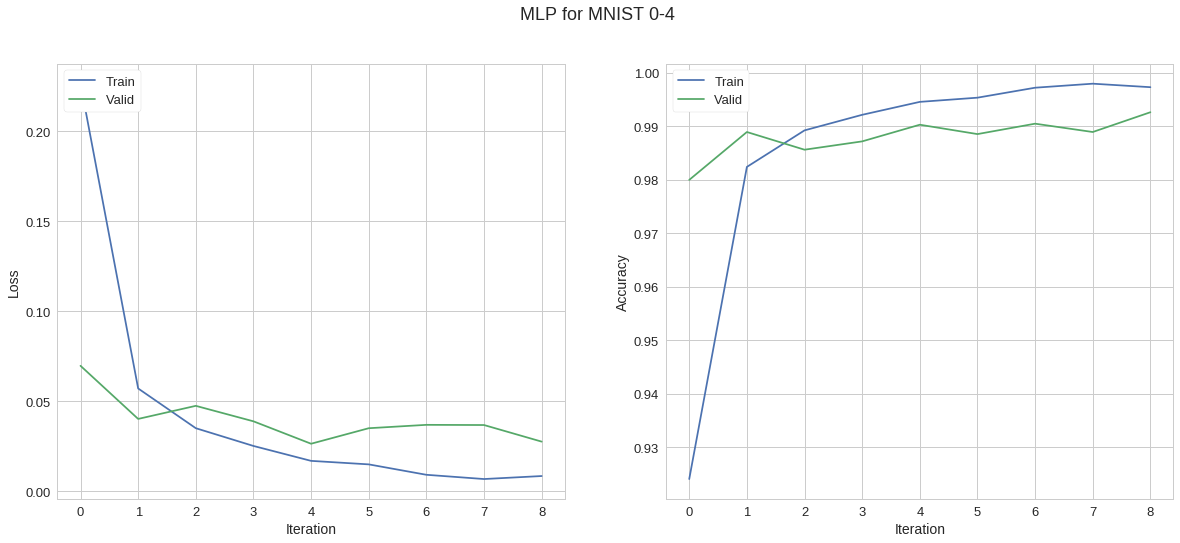

In [24]:
plt.figure(figsize=(20, 8))
plt.suptitle("MLP for MNIST 0-4", fontsize=18)

plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)

plt.plot(hist.history["acc"], label="Train")
plt.plot(hist.history["val_acc"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Load the best model

In [25]:
model = load_model(filepath="chkpt")

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Evaluate it

In [26]:
pd.DataFrame(data=[model.evaluate(X_train_l5, y_train_l5, verbose=0), 
                   model.evaluate(X_valid_l5, y_valid_l5, verbose=0)], 
             index=["Train", "Validation"], 
             columns=["Loss", "Accuracy"])

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


,Loss,Accuracy
Train,0.011086,0.996634
Validation,0.026458,0.990270


## Fine-tuning
* Create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a fresh new one.
* Train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?
* Try caching the frozen layers, and train the model again: how much faster is it now?
* Try again reusing just four hidden layers instead of five. Can you achieve a higher precision?
* Now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?

Load previously trained model

In [27]:
model = load_model(filepath="chkpt", compile=False)

Freeze all the layers of the feature extractor part and reinitialize layers of classification part

In [28]:
sess = K.get_session()
for i in range(extractor_len):
    model.layers[i].trainable = False
for i in range(extractor_len, len(model.layers)):
    l = model.layers[i]
    new_weights = l.kernel_initializer(l.get_weights()[0].shape).eval(session = sess)
    new_bias = l.bias_initializer(l.get_weights()[1].shape).eval(session = sess)
    l.set_weights([new_weights, new_bias])

Recompile model

In [29]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

As one can notice we have onle $505$ trainable paramters

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 119,405
Trainable params: 505
Non-trainable params: 118,900
_________________________________________________________________


Let's cut down the size of the training sample to 100 examples per class and shuffle them

In [31]:
X_train_g5_reduced = X_train_g5[:500]
y_train_g5_reduced = y_train_g5[:500]
for i in range(5):
    idx = np.argmax(y_train_g5, axis=1) == i
    X_train_g5_reduced[100 * i : 100 * (i + 1)] = X_train_g5[idx][:100]
    y_train_g5_reduced[100 * i : 100 * (i + 1)] = y_train_g5[idx][:100]
idx = np.random.permutation(500)
X_train_g5_reduced = X_train_g5_reduced[idx]
y_train_g5_reduced = y_train_g5_reduced[idx]

And finally fine-tune model only on small amount of data

In [32]:
%%time
hist = model.fit(X_train_g5_reduced, y_train_g5_reduced, 
                 batch_size=16, 
                 epochs=150, 
                 verbose=0, 
                 validation_data=(X_valid_g5, y_valid_g5))

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


CPU times: user 1min 35s, sys: 11.1 s, total: 1min 46s
Wall time: 1min 9s


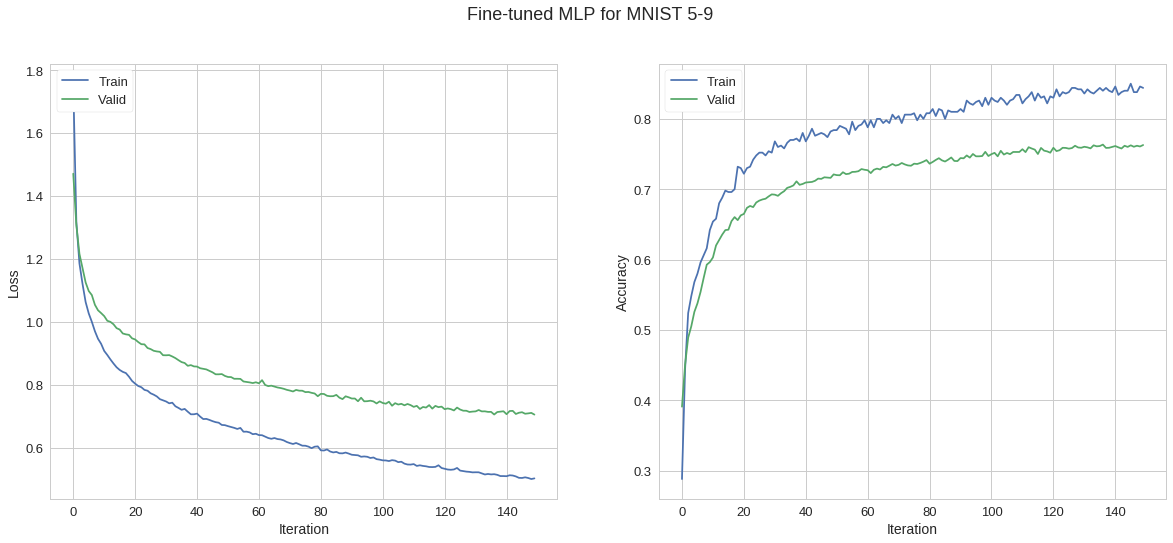

In [33]:
plt.figure(figsize=(20, 8))
plt.suptitle("Fine-tuned MLP for MNIST 5-9", fontsize=18)

plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)

plt.plot(hist.history["acc"], label="Train")
plt.plot(hist.history["val_acc"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Evaluate model

In [34]:
pd.DataFrame(data=[model.evaluate(X_train_g5_reduced, y_train_g5_reduced, verbose=0), 
                   model.evaluate(X_valid_g5, y_valid_g5, verbose=0)], 
             index=["Train", "Validation"], 
             columns=["Loss", "Accuracy"])

,Loss,Accuracy
Train,0.493295,0.846000
Validation,0.705935,0.762806


As one can notice quality is not so good but recall that we used only 500 examples. Also the training took a while.

### Caching
We can easily resolve the timing issue. For that purpose remember that we froze all the layers except the last one. Thus the weights do not change during the whole training procedure. Therefore we can precalculate outputs of the feature extractor in advance for the train and validation set and then fit only classification part

Load previously trained model

In [35]:
model_cached = load_model(filepath="chkpt", compile=True)

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Create a model that takes an output from the intermediate layer

In [36]:
feature_extractor_model = Model(inputs=model_cached.input,
                                outputs=model_cached.layers[extractor_len - 1].output)

Extract features

In [37]:
X_train_g5_reduced_features = feature_extractor_model.predict(X_train_g5_reduced)
X_valid_g5_features = feature_extractor_model.predict(X_valid_g5)

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Build and compile a new model with only classification layers

In [38]:
model_classification = Sequential([Dense(units=5, 
                                         activation="softmax", 
                                         input_shape=(X_train_g5_reduced_features.shape[1], ))])
model_classification.compile(loss="categorical_crossentropy",
                             optimizer="adam",
                             metrics=["accuracy"])

Train it

In [39]:
%%time
hist = model_classification.fit(X_train_g5_reduced_features, y_train_g5_reduced, 
                                batch_size=16, 
                                epochs=150, 
                                verbose=0, 
                                validation_data=(X_valid_g5_features, y_valid_g5))

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


CPU times: user 59.4 s, sys: 7.14 s, total: 1min 6s
Wall time: 41.8 s


Evaluation. The quality should be the same as without caching. The only difference might come from randomness.

In [41]:
pd.DataFrame(data=[model_classification.evaluate(X_train_g5_reduced_features, y_train_g5_reduced, verbose=0), 
                   model_classification.evaluate(X_valid_g5_features, y_valid_g5, verbose=0)], 
             index=["Train", "Validation"], 
             columns=["Loss", "Accuracy"])

,Loss,Accuracy
Train,0.495256,0.840000
Validation,0.708056,0.766098


One can see that the time is smaller but not significant. This is mainly due to the fact the most of the time is spent for checking the validation quality because of its big size.

But on other tasks (see `DogsAndCats` notebook) where the feature extractor part is much bigger (usually it is like that, e.g., VGG) this technique can give a considerable boost in time.

### Deep fine-tuning

After training classification part for reasonable amount of epochs (until something resembles convergence) one can imagine unfreezing deeper layers.

Usually they are being co-trained in ensemble with classication part but with smaller learning rate.

Also notice that we did not get any significant gain from caching so we won't use it later on in this notebook.

Here we utilize model trained before in section 3.2 and unfreeze two more layers of the extractor part

In [42]:
for i in range(extractor_len - 2, extractor_len):
    model.layers[i].trainable = True

Now we have more trainable parameters

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 119,405
Trainable params: 20,705
Non-trainable params: 98,700
_________________________________________________________________


Let's recompile our model and set smaller learning rate

In [44]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=0.0001),
              metrics=["accuracy"])

And train it

In [45]:
%%time
hist_ft = model.fit(X_train_g5_reduced, y_train_g5_reduced, 
                    batch_size=16, 
                    epochs=100, 
                    verbose=0, 
                    validation_data=(X_valid_g5, y_valid_g5))

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


CPU times: user 57.7 s, sys: 6.62 s, total: 1min 4s
Wall time: 40.9 s


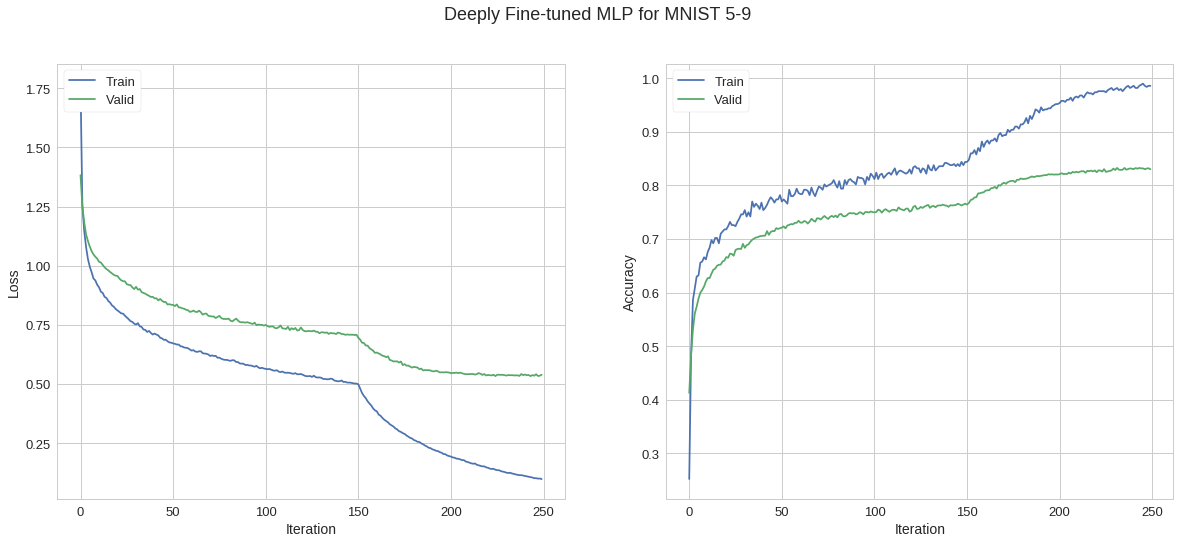

In [46]:
plt.figure(figsize=(20, 8))
plt.suptitle("Deeply Fine-tuned MLP for MNIST 5-9", fontsize=18)

plt.subplot(121)
plt.plot(hist.history["loss"] + hist_ft.history["loss"], label="Train")
plt.plot(hist.history["val_loss"] + hist_ft.history["val_loss"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)

plt.plot(hist.history["acc"] + hist_ft.history["acc"], label="Train")
plt.plot(hist.history["val_acc"] + hist_ft.history["val_acc"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

As one can notice this model is worse that the one trained starting at randomly initialized weights. But recall that we used only **100** examples per class in training mode! In this context this result does not look so terrible. 

In this case we have sufficiently small both model and data to be able to train everything from scratch and it even may work better (you can try). But in case of much more complex feature extractor (e.g. VGG for pictures pre-trained on the whole ImageNet database) it would take days or even weeks to train a model from scratch while this approach can save you a lot of time and computational power. Moreover in most cases you would have small dataset which would not be enough to train big, complex and good feature extractor like VGG.

## Siamese networks and transfer learning
* In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data. Start by building two DNNs (let’s call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ReLU activation. Next, add a single output layer on top of both DNNs. You should use Keras' [merge](https://keras.io/layers/merge/) layer and `Concatenate` mode in particular with `axis=1` to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the output layer. This output layer should contain a single neuron using the logistic activation function.
* Split (in stratified manner) the MNIST training set in two sets: split №1 should containing 55,000 images, and split №2 should contain contain 5,000 images. Create a function (or a class) that generates a batch of examples where each instance is a pair of MNIST images picked from split №1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes. Note that ideally this function should return a `generator` python object which will generate objects on-the-fly.
* Train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not.
* Now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on with 10 neurons. Train this network on split №2 and see if you can achieve high performance despite having only 500 images per class.

Let's creat two braches of the model:

In [47]:
config = {"units": 100, 
          "activation": "relu", 
          "kernel_initializer": "he_normal"}

DNN A:

In [48]:
inp_a = Input(shape=(X_train.shape[1],), name="input_a")
dnn_a = Dense(**config)(inp_a)
dnn_a = Dense(**config)(dnn_a)
dnn_a = Dense(**config)(dnn_a)
dnn_a = Dense(**config)(dnn_a)
dnn_a = Dense(**config)(dnn_a)

DNN B:

In [49]:
inp_b = Input(shape=(X_train.shape[1],), name="input_b")
dnn_b = Dense(**config)(inp_b)
dnn_b = Dense(**config)(dnn_b)
dnn_b = Dense(**config)(dnn_b)
dnn_b = Dense(**config)(dnn_b)
dnn_b = Dense(**config)(dnn_b)

Merge:

In [50]:
output = Concatenate(axis=1)([dnn_a, dnn_b])

Discriminator:

In [51]:
output = Dense(**config)(output)
output = Dense(units=1, activation="sigmoid")(output)

Build final model:

In [52]:
model_siamese = Model(inputs=[inp_a, inp_b], outputs=[output])

And compile it:

In [53]:
model_siamese.compile(optimizer=Adam(lr=0.001), 
                      loss="binary_crossentropy", 
                      metrics=["accuracy"])

And its graphical representation

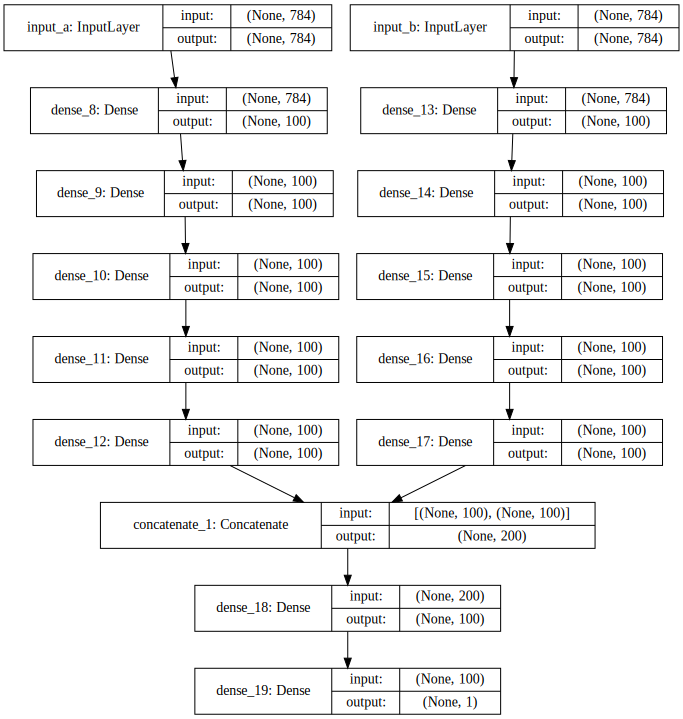

In [54]:
SVG(model_to_dot(model_siamese, show_shapes=True).create(prog="dot", format="svg"))

One more idea that one can explore is to use shared weights for both branches of DNN. Intuitively it should work because both branches serve to extract meaningful representation from initial picture.

### Data preparation for siamese NN

Split training for two:
* Set of pairs to train siamese network: $55000$ examples
* Set of single digits to build a classifier on top of the feature extractor from siamese network: $5000$ examples

In [55]:
X_train_siamese, X_train_final, y_train_siamese, y_train_final = \
            train_test_split(X_train, y_train, test_size=5./60, stratify=y_train)

Define a function to create paired dataset for siamese network.

Here we do it in static manner which means that we generate dataset beforehand. The better way is to create a `generator` object which will create examples on-the-fly. `Keras` supports such kind of training via `fig_generator()` method (see `CTC_CAPTCHA` notebook)

In [56]:
def create_pairs(X, y):
    '''
    Positive and negative pair creation.
    Alternates between positive and negative pairs.
    
    Args:
        X(ndarray): 
    ''' 
    pairs = []
    labels = []
    # list which contains arrays of indices of each digit
    digit_indices = [np.where(y == i)[0] for i in range(10)]
    # size of the training set of pairs per digit
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    # for all digits
    for d in range(10):
        # iterate over nunmber of pairs
        for i in range(n):
            # positive example
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[X[z1], X[z2]]]
            # random negative example class
            inc = np.random.randint(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[X[z1], X[z2]]]
            # labels
            labels += [1, 0]
    
    return np.array(pairs), np.array(labels)

Create dataset itself

In [57]:
X_paired_train, y_paired_train = create_pairs(X_train_siamese, y_train_siamese)
X_paired_valid, y_paired_valid = create_pairs(X_valid, y_valid)

### Train siamese model

In [58]:
%%time
hist_siamese = model_siamese.fit(x=[X_paired_train[:, 0], X_paired_train[:, 1]], 
                                 y=y_paired_train, 
                                 batch_size=128, 
                                 epochs=10, 
                                 validation_data=([X_paired_valid[:, 0], X_paired_valid[:, 1]], 
                                                  y_paired_valid))

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 99360 samples, validate on 17820 samples
Epoch 1/10
99360/99360 [==============================] - 7s - loss: 0.3776 - acc: 0.8245 - val_loss: 0.2462 - val_acc: 0.9033
Epoch 2/10
99360/99360 [==============================] - 8s - loss: 0.1804 - acc: 0.9316 - val_loss: 0.1631 - val_acc: 0.9351
Epoch 3/10
99360/99360 [==============================] - 7s - loss: 0.1091 - acc: 0.9607 - val_loss: 0.1032 - val_acc: 0.9640
Epoch 4/10
99360/99360 [==============================] - 9s - loss: 0.0749 - acc: 0.9740 - val_loss: 0.0995 - val_acc: 0.9662
Epoch 5/10
99360/99360 [==============================] - 8s - loss: 0.0579 - acc: 0.9796 - val_loss: 0.1015 - val_acc: 0.9657
Epoch 6/10
99360/99360 [==============================] - 8s - loss: 0.0490 - acc: 0.9828 - val_loss: 0.0813 - val_acc: 0.9724
Epoch 7/10
99360/99360 [==============================] - 8s - loss: 0.0397 - acc: 0.9861 - val_loss: 0.0979 - val_acc: 0.9686
Epoch 8/10
99360/99360 [==============================] - 8s 

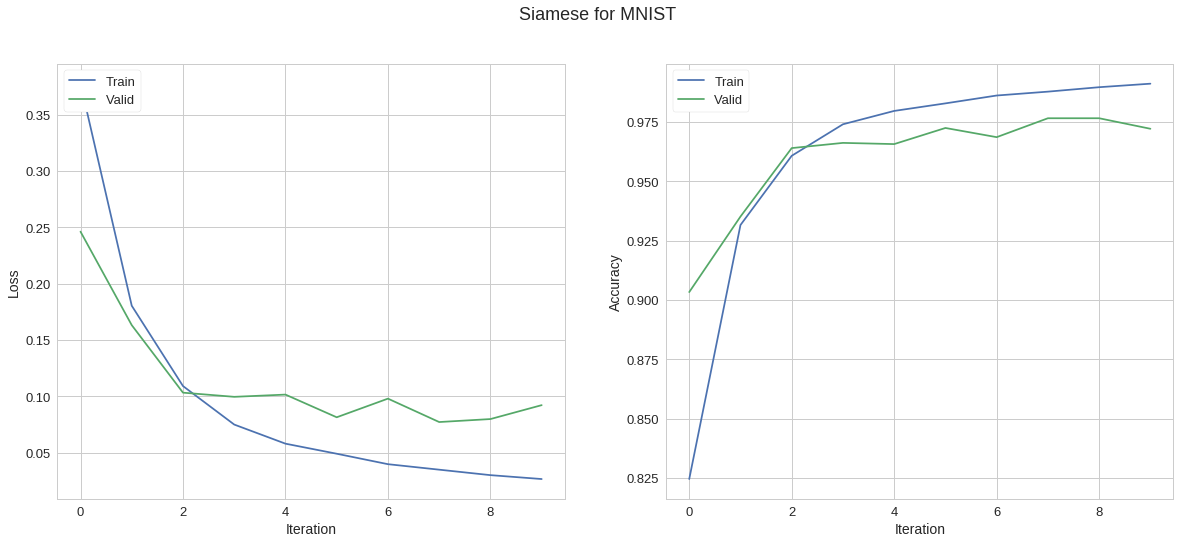

In [59]:
plt.figure(figsize=(20, 8))
plt.suptitle("Siamese for MNIST", fontsize=18)

plt.subplot(121)
plt.plot(hist_siamese.history["loss"], label="Train")
plt.plot(hist_siamese.history["val_loss"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)

plt.plot(hist_siamese.history["acc"], label="Train")
plt.plot(hist_siamese.history["val_acc"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

### Classification model

Now let's build simple softmax classification layer on top of the DNN A branch.

In [60]:
classification_layer = Dense(units=10, 
                             activation="softmax")(dnn_a)

Create new model

In [61]:
model_a = Model(inputs=[inp_a], outputs=[classification_layer])

Freeze feature extractor pre-trained layers

In [62]:
for layer_idx in range(len(model_a.layers) - 1):
    model_a.layers[layer_idx].trainable = False

See how many trainable parameters we have:

In [63]:
model_a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_a (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
Total para

Compile model

In [64]:
model_a.compile(optimizer="adam", 
                loss="categorical_crossentropy", 
                metrics=["accuracy"])

Fitting:

In [65]:
%%time
hist_a = model_a.fit(x=X_train_final, 
                     y=to_categorical(y_train_final), 
                     batch_size=32, 
                     epochs=10, 
                     validation_data=(X_valid, 
                                      to_categorical(y_valid)))

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 5000 samples, validate on 10000 samples
Epoch 1/10
5000/5000 [==============================] - 0s - loss: 0.7886 - acc: 0.7818 - val_loss: 0.1721 - val_acc: 0.9619
Epoch 2/10
5000/5000 [==============================] - 0s - loss: 0.1466 - acc: 0.9664 - val_loss: 0.1349 - val_acc: 0.9659
Epoch 3/10
5000/5000 [==============================] - 0s - loss: 0.1222 - acc: 0.9700 - val_loss: 0.1247 - val_acc: 0.9671
Epoch 4/10
5000/5000 [==============================] - 0s - loss: 0.1114 - acc: 0.9710 - val_loss: 0.1181 - val_acc: 0.9683
Epoch 5/10
5000/5000 [==============================] - 0s - loss: 0.1054 - acc: 0.9714 - val_loss: 0.1153 - val_acc: 0.9685
Epoch 6/10
5000/5000 [==============================] - 0s - loss: 0.1012 - acc: 0.9712 - val_loss: 0.1147 - val_acc: 0.9693
Epoch 7/10
5000/5000 [==============================] - 0s - loss: 0.0981 - acc: 0.9722 - val_loss: 0.1138 - val_acc: 0.9694
Epoch 8/10
5000/5000 [==============================] - 0s - loss: 0.0960 - 

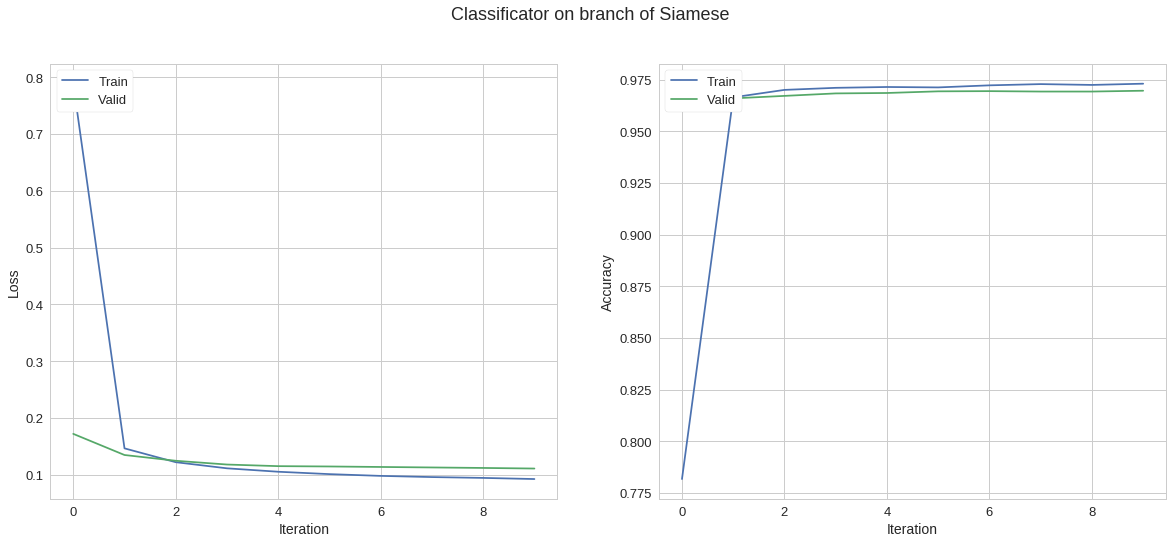

In [66]:
plt.figure(figsize=(20, 8))
plt.suptitle("Classificator on branch of Siamese", fontsize=18)

plt.subplot(121)
plt.plot(hist_a.history["loss"], label="Train")
plt.plot(hist_a.history["val_loss"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)

plt.plot(hist_a.history["acc"], label="Train")
plt.plot(hist_a.history["val_acc"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Evaluation

In [67]:
pd.DataFrame(data=[model_a.evaluate(X_train_final, to_categorical(y_train_final), verbose=0), 
                   model_a.evaluate(X_valid, to_categorical(y_valid), verbose=0)], 
             index=["Train", "Validation"], 
             columns=["Loss", "Accuracy"])

,Loss,Accuracy
Train,0.089160,0.9736
Validation,0.111053,0.9696


Notice that we were able to achieve this quality using pre-trained siamese network and only 500 example per class for fine-tuning.

#### From scratch benchmark

Let's benchmark our model against the same model but trained from scratch on the same 500 examples per class dataset

In [68]:
inp_bench = Input(shape=(X_train.shape[1],), name="input_a")
dnn_bench = Dense(**config)(inp_bench)
dnn_bench = Dense(**config)(dnn_bench)
dnn_bench = Dense(**config)(dnn_bench)
dnn_bench = Dense(**config)(dnn_bench)
dnn_bench = Dense(**config)(dnn_bench)
dnn_bench = Dense(units=10, activation="softmax")(dnn_bench)

Build and compile

In [69]:
model_bench = Model(inputs=[inp_bench], outputs=[dnn_bench])
model_bench.compile(optimizer="adam", 
                    loss="categorical_crossentropy", 
                    metrics=["accuracy"])

Fit

In [70]:
%%time
hist_bench = model_bench.fit(x=X_train_final, 
                             y=to_categorical(y_train_final), 
                             batch_size=32, 
                             epochs=10, 
                             validation_data=(X_valid, 
                                              to_categorical(y_valid)))

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 5000 samples, validate on 10000 samples
Epoch 1/10
5000/5000 [==============================] - 1s - loss: 0.7753 - acc: 0.7516 - val_loss: 0.3543 - val_acc: 0.8893
Epoch 2/10
5000/5000 [==============================] - 1s - loss: 0.2592 - acc: 0.9202 - val_loss: 0.2969 - val_acc: 0.9103
Epoch 3/10
5000/5000 [==============================] - 1s - loss: 0.1630 - acc: 0.9494 - val_loss: 0.3035 - val_acc: 0.9119
Epoch 4/10
5000/5000 [==============================] - 1s - loss: 0.1203 - acc: 0.9624 - val_loss: 0.2943 - val_acc: 0.9180
Epoch 5/10
5000/5000 [==============================] - 0s - loss: 0.1089 - acc: 0.9660 - val_loss: 0.2466 - val_acc: 0.9295
Epoch 6/10
5000/5000 [==============================] - 0s - loss: 0.0684 - acc: 0.9786 - val_loss: 0.2755 - val_acc: 0.9275
Epoch 7/10
5000/5000 [==============================] - 1s - loss: 0.0548 - acc: 0.9804 - val_loss: 0.3372 - val_acc: 0.9156
Epoch 8/10
5000/5000 [==============================] - 1s - loss: 0.0498 - 

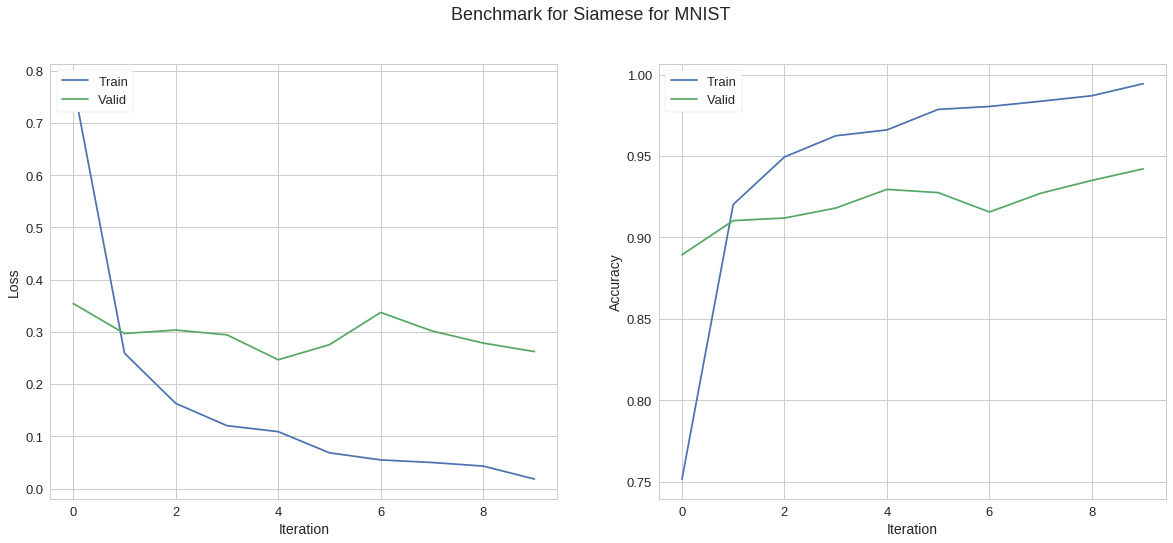

In [71]:
plt.figure(figsize=(20, 8))
plt.suptitle("Benchmark for Siamese for MNIST", fontsize=18)

plt.subplot(121)
plt.plot(hist_bench.history["loss"], label="Train")
plt.plot(hist_bench.history["val_loss"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)

plt.plot(hist_bench.history["acc"], label="Train")
plt.plot(hist_bench.history["val_acc"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Evaluate

In [72]:
pd.DataFrame(data=[model_bench.evaluate(X_train_final, to_categorical(y_train_final), verbose=0), 
                   model_bench.evaluate(X_valid, to_categorical(y_valid), verbose=0)], 
             index=["Train", "Validation"], 
             columns=["Loss", "Accuracy"])

,Loss,Accuracy
Train,0.016115,0.9962
Validation,0.262307,0.9421


As one can notice, validation accuracy is lower. It confirms that our feature extractor learnt on bigger amount of data indeed gives an advantage.